<a href="https://colab.research.google.com/github/youness-marrakchi/tmr-vis-v3/blob/main/tmr_vis_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install timm albumentations grad-cam wandb scikit-learn seaborn kagglehub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=4c4f75d22c39bc9c3aee3c72d041d9de38f300a846e1794b1bfc1f62b692bdf1
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:

# Import required libraries
import os
import shutil
from kagglehub import dataset_download
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import kagglehub


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Verify the imports worked
print("Setup completed successfully!")

Using device: cuda
Setup completed successfully!


In [ ]:
import os
import shutil
import kagglehub
import glob

def setup_dataset():
    # Download dataset
    print("Downloading dataset...")
    path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    print(f"Dataset downloaded to: {path}")

    # Get the actual path where Kaggle downloaded the dataset
    kaggle_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"

    # Create project data directory
    project_data_path = "/content/brain_tumor_data"
    os.makedirs(project_data_path, exist_ok=True)

    print("\nVerifying dataset structure...")

    # Verify the downloaded data structure
    if os.path.exists(os.path.join(kaggle_path, "Training")) and os.path.exists(os.path.join(kaggle_path, "Testing")):
        print("Found Training and Testing directories")

        # Create directories
        for split in ['Training', 'Testing']:
            split_path = os.path.join(project_data_path, split)
            os.makedirs(split_path, exist_ok=True)

            # Create class directories
            for class_name in ['glioma', 'meningioma', 'notumor', 'pituitary']:
                class_path = os.path.join(split_path, class_name)
                os.makedirs(class_path, exist_ok=True)

                # Copy files
                src_dir = os.path.join(kaggle_path, split, class_name)
                if os.path.exists(src_dir):
                    for file in glob.glob(os.path.join(src_dir, '*')):
                        shutil.copy2(file, class_path)
                else:
                    print(f"Warning: Source directory not found: {src_dir}")

        # Verify the copy
        print("\nVerifying copied dataset structure:")
        for split in ['Training', 'Testing']:
            print(f"\n{split} data:")
            for class_name in ['glioma', 'meningioma', 'notumor', 'pituitary']:
                class_path = os.path.join(project_data_path, split, class_name)
                if os.path.exists(class_path):
                    num_images = len(os.listdir(class_path))
                    print(f"  - {class_name}: {num_images} images")
                else:
                    print(f"  - {class_name}: Directory not found!")

        return project_data_path
    else:
        print("ERROR: Expected directory structure not found in downloaded dataset!")
        print(f"Contents of {kaggle_path}:")
        for root, dirs, files in os.walk(kaggle_path):
            level = root.replace(kaggle_path, '').count(os.sep)
            indent = ' ' * 4 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 4 * (level + 1)
            for f in files[:5]:
                print(f"{subindent}{f}")
            if len(files) > 5:
                print(f"{subindent}...")
        return None

# Run setup and verification
print("Setting up dataset...")
data_path = setup_dataset()

if data_path and os.path.exists(data_path):
    print(f"\nDataset successfully organized at: {data_path}")
    print("Ready to proceed with model training!")
else:
    print("\nERROR: Dataset setup failed. Please check the errors above.")

Setting up dataset...


100%|██████████| 149M/149M [00:03<00:00, 40.7MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1

Verifying dataset structure...
Found Training and Testing directories

Verifying copied dataset structure:

Training data:
  - glioma: 1321 images
  - meningioma: 1339 images
  - notumor: 1595 images
  - pituitary: 1457 images

Testing data:
  - glioma: 300 images
  - meningioma: 306 images
  - notumor: 405 images
  - pituitary: 300 images

Dataset successfully organized at: /content/brain_tumor_data
Ready to proceed with model training!


In [ ]:
# Cell 1: Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        # Load data paths
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, split, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label


In [ ]:
# Model Definition
class BrainTumorModel(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(n_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Cell 3: Data Transforms
def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2()
        ])

In [ ]:
# Cell 4: Training Functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if batch_idx % 20 == 0:  # Print progress every 20 batches
            print(f'Batch [{batch_idx}/{len(loader)}] Loss: {loss.item():.4f}')

    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return (total_loss / len(loader), 100. * correct / total,
            np.array(all_preds), np.array(all_labels))


In [ ]:

# Cell 5: Visualization Functions
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [ ]:

# Cell 6: Main Training Loop
def main():
    # Setup
    data_path = "/content/brain_tumor_data"

    # Datasets
    train_dataset = BrainTumorDataset(data_path, get_transforms('train'), 'Training')
    val_dataset = BrainTumorDataset(data_path, get_transforms('val'), 'Testing')

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Model
    model = BrainTumorModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=3)

    # Training
    num_epochs = 30
    best_val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        train_loss, train_acc = train_epoch(model, train_loader,
                                          criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_labels = validate(model, val_loader,
                                                          criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Plot current progress
        if (epoch + 1) % 5 == 0:  # Plot every 5 epochs
            plot_training_curves(train_losses, train_accs, val_losses, val_accs)

    # Final Evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    _, final_acc, final_preds, final_labels = validate(model, val_loader,
                                                     criterion, device)

    # Plot final results
    plot_training_curves(train_losses, train_accs, val_losses, val_accs)
    plot_confusion_matrix(final_labels, final_preds, train_dataset.classes)

    # Print Classification Report
    print('\nClassification Report:')
    print(classification_report(final_labels, final_preds,
                              target_names=train_dataset.classes))


Training samples: 5712
Validation samples: 1311


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Epoch 1/30
--------------------
Batch [0/179] Loss: 1.3574
Batch [20/179] Loss: 0.3656
Batch [40/179] Loss: 0.3514
Batch [60/179] Loss: 0.2559
Batch [80/179] Loss: 0.5961
Batch [100/179] Loss: 0.2858
Batch [120/179] Loss: 0.2598
Batch [140/179] Loss: 0.5129
Batch [160/179] Loss: 0.1394
Train Loss: 0.3966, Train Acc: 85.85%
Val Loss: 0.2578, Val Acc: 90.31%

Epoch 2/30
--------------------
Batch [0/179] Loss: 0.4308
Batch [20/179] Loss: 0.2104
Batch [40/179] Loss: 0.3955
Batch [60/179] Loss: 0.2552
Batch [80/179] Loss: 0.1177
Batch [100/179] Loss: 0.1447
Batch [120/179] Loss: 0.0961
Batch [140/179] Loss: 0.1781
Batch [160/179] Loss: 0.1167
Train Loss: 0.2471, Train Acc: 91.32%
Val Loss: 0.1417, Val Acc: 95.04%

Epoch 3/30
--------------------
Batch [0/179] Loss: 0.2120
Batch [20/179] Loss: 0.1999
Batch [40/179] Loss: 0.0582
Batch [60/179] Loss: 0.0850
Batch [80/179] Loss: 0.2501
Batch [100/179] Loss: 0.2378
Batch [120/179] Loss: 0.0997
Batch [140/179] Loss: 0.4893
Batch [160/179] Loss:

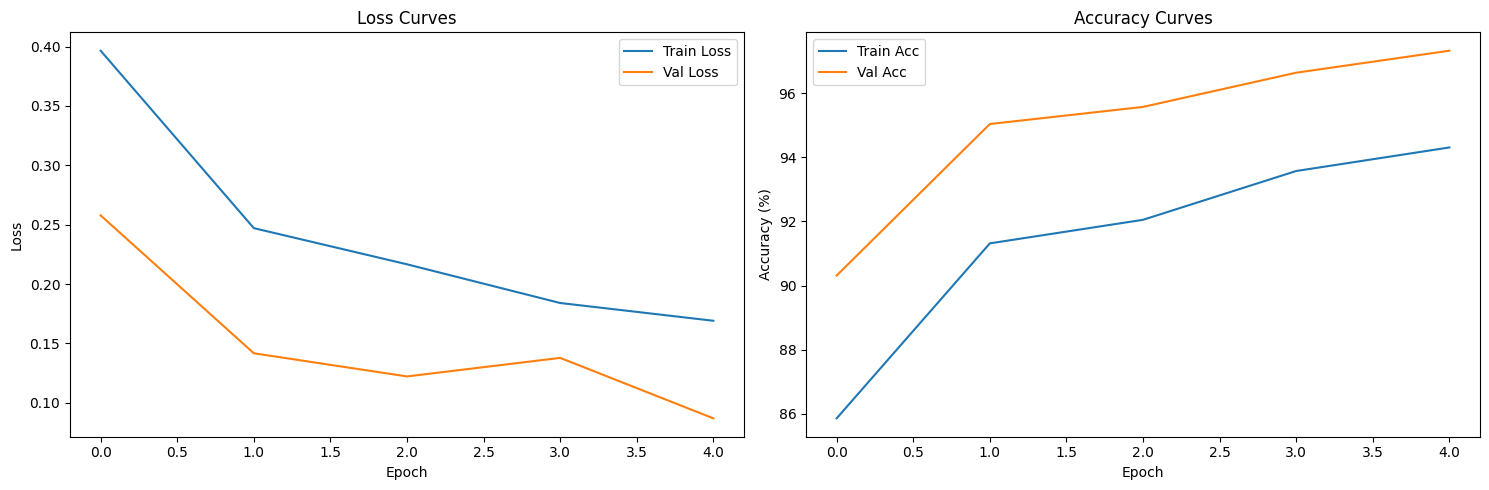


Epoch 6/30
--------------------
Batch [0/179] Loss: 0.0954
Batch [20/179] Loss: 0.2714
Batch [40/179] Loss: 0.0665
Batch [60/179] Loss: 0.0393
Batch [80/179] Loss: 0.0496
Batch [100/179] Loss: 0.0857
Batch [120/179] Loss: 0.1465
Batch [140/179] Loss: 0.0904
Batch [160/179] Loss: 0.1440
Train Loss: 0.1683, Train Acc: 94.33%
Val Loss: 0.0959, Val Acc: 96.95%

Epoch 7/30
--------------------
Batch [0/179] Loss: 0.0391
Batch [20/179] Loss: 0.0394
Batch [40/179] Loss: 0.0445
Batch [60/179] Loss: 0.0529
Batch [80/179] Loss: 0.1780
Batch [100/179] Loss: 0.0760
Batch [120/179] Loss: 0.2981
Batch [140/179] Loss: 0.0765
Batch [160/179] Loss: 0.2513
Train Loss: 0.1469, Train Acc: 94.78%
Val Loss: 0.1019, Val Acc: 96.19%

Epoch 8/30
--------------------
Batch [0/179] Loss: 0.1357
Batch [20/179] Loss: 0.1708
Batch [40/179] Loss: 0.1288
Batch [60/179] Loss: 0.1316
Batch [80/179] Loss: 0.1126
Batch [100/179] Loss: 0.0243
Batch [120/179] Loss: 0.2155
Batch [140/179] Loss: 0.0982
Batch [160/179] Loss:

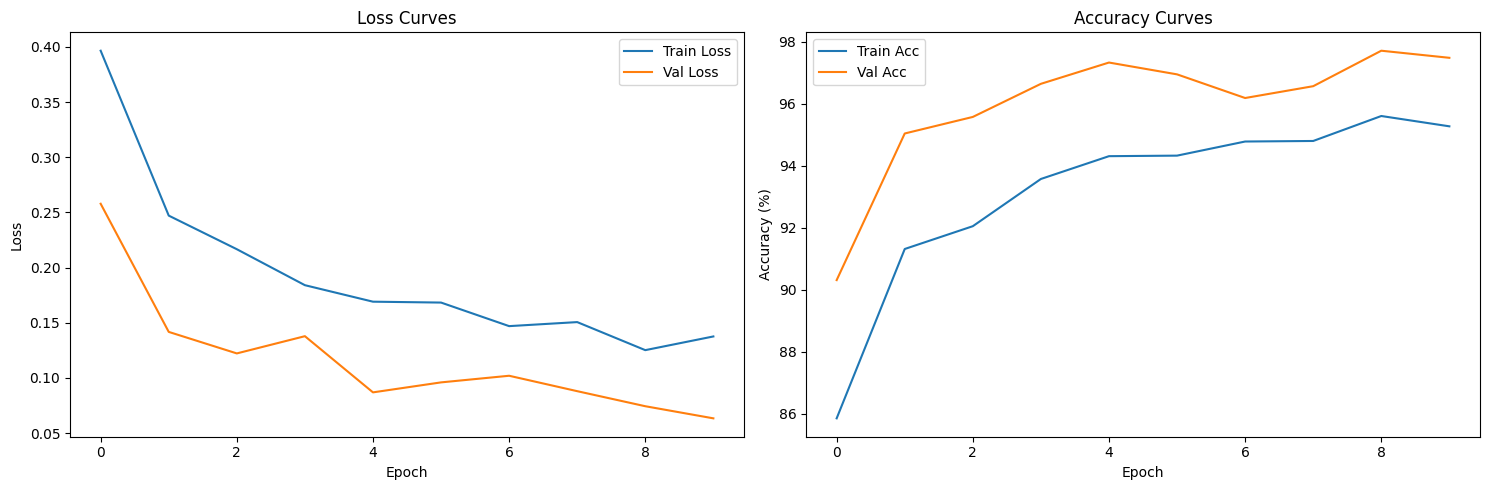


Epoch 11/30
--------------------
Batch [0/179] Loss: 0.1483
Batch [20/179] Loss: 0.1422
Batch [40/179] Loss: 0.1683
Batch [60/179] Loss: 0.0993
Batch [80/179] Loss: 0.0359
Batch [100/179] Loss: 0.0776
Batch [120/179] Loss: 0.1183
Batch [140/179] Loss: 0.0659
Batch [160/179] Loss: 0.0199
Train Loss: 0.1276, Train Acc: 95.40%
Val Loss: 0.0959, Val Acc: 96.80%

Epoch 12/30
--------------------
Batch [0/179] Loss: 0.0446
Batch [20/179] Loss: 0.1463
Batch [40/179] Loss: 0.0516
Batch [60/179] Loss: 0.1082
Batch [80/179] Loss: 0.2976
Batch [100/179] Loss: 0.0595
Batch [120/179] Loss: 0.1441
Batch [140/179] Loss: 0.0920
Batch [160/179] Loss: 0.1104
Train Loss: 0.1296, Train Acc: 95.45%
Val Loss: 0.0751, Val Acc: 97.10%

Epoch 13/30
--------------------
Batch [0/179] Loss: 0.3010
Batch [20/179] Loss: 0.3968
Batch [40/179] Loss: 0.0341
Batch [60/179] Loss: 0.0192
Batch [80/179] Loss: 0.2385
Batch [100/179] Loss: 0.0210
Batch [120/179] Loss: 0.1834
Batch [140/179] Loss: 0.3497
Batch [160/179] Lo

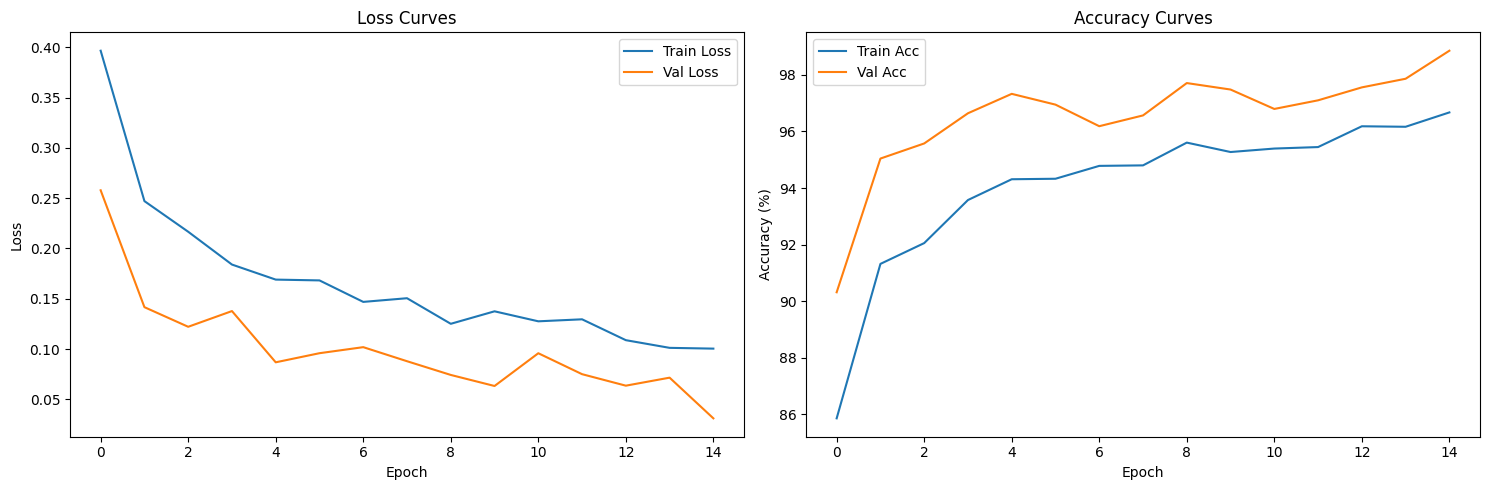


Epoch 16/30
--------------------
Batch [0/179] Loss: 0.1582
Batch [20/179] Loss: 0.0306
Batch [40/179] Loss: 0.1696
Batch [60/179] Loss: 0.1002
Batch [80/179] Loss: 0.1064
Batch [100/179] Loss: 0.0299
Batch [120/179] Loss: 0.1316
Batch [140/179] Loss: 0.0227
Batch [160/179] Loss: 0.0832
Train Loss: 0.0804, Train Acc: 97.34%
Val Loss: 0.0226, Val Acc: 99.24%

Epoch 17/30
--------------------
Batch [0/179] Loss: 0.0289
Batch [20/179] Loss: 0.0474
Batch [40/179] Loss: 0.0335
Batch [60/179] Loss: 0.1530
Batch [80/179] Loss: 0.0104
Batch [100/179] Loss: 0.0095
Batch [120/179] Loss: 0.0207
Batch [140/179] Loss: 0.1307
Batch [160/179] Loss: 0.1838
Train Loss: 0.0643, Train Acc: 97.81%
Val Loss: 0.0300, Val Acc: 99.24%

Epoch 18/30
--------------------
Batch [0/179] Loss: 0.1078
Batch [20/179] Loss: 0.1212
Batch [40/179] Loss: 0.0478
Batch [60/179] Loss: 0.1195
Batch [80/179] Loss: 0.2110
Batch [100/179] Loss: 0.0097
Batch [120/179] Loss: 0.0039
Batch [140/179] Loss: 0.0204
Batch [160/179] Lo

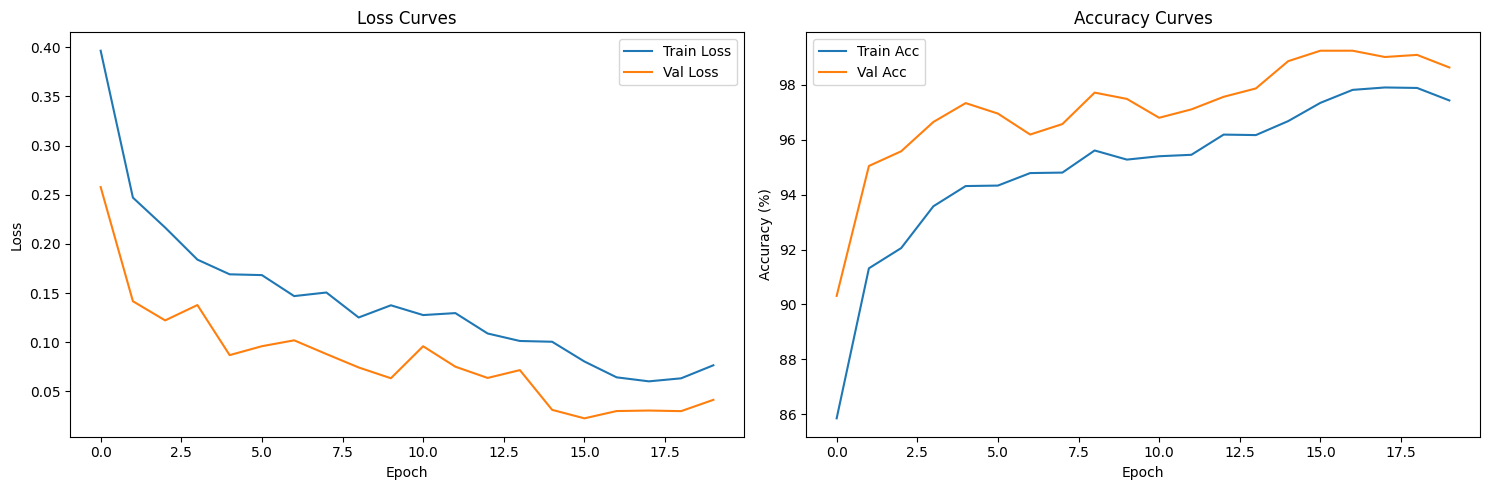


Epoch 21/30
--------------------
Batch [0/179] Loss: 0.0808
Batch [20/179] Loss: 0.0192
Batch [40/179] Loss: 0.1403
Batch [60/179] Loss: 0.0289
Batch [80/179] Loss: 0.0270
Batch [100/179] Loss: 0.0526
Batch [120/179] Loss: 0.0801
Batch [140/179] Loss: 0.0480
Batch [160/179] Loss: 0.1132
Train Loss: 0.0604, Train Acc: 97.67%
Val Loss: 0.0210, Val Acc: 99.39%

Epoch 22/30
--------------------
Batch [0/179] Loss: 0.0038
Batch [20/179] Loss: 0.0229
Batch [40/179] Loss: 0.0492
Batch [60/179] Loss: 0.1789
Batch [80/179] Loss: 0.0359
Batch [100/179] Loss: 0.0142
Batch [120/179] Loss: 0.0227
Batch [140/179] Loss: 0.0609
Batch [160/179] Loss: 0.1017
Train Loss: 0.0526, Train Acc: 98.30%
Val Loss: 0.0189, Val Acc: 99.54%

Epoch 23/30
--------------------
Batch [0/179] Loss: 0.0155
Batch [20/179] Loss: 0.0732
Batch [40/179] Loss: 0.2765
Batch [60/179] Loss: 0.0610
Batch [80/179] Loss: 0.0119
Batch [100/179] Loss: 0.0425
Batch [120/179] Loss: 0.0106
Batch [140/179] Loss: 0.0851
Batch [160/179] Lo

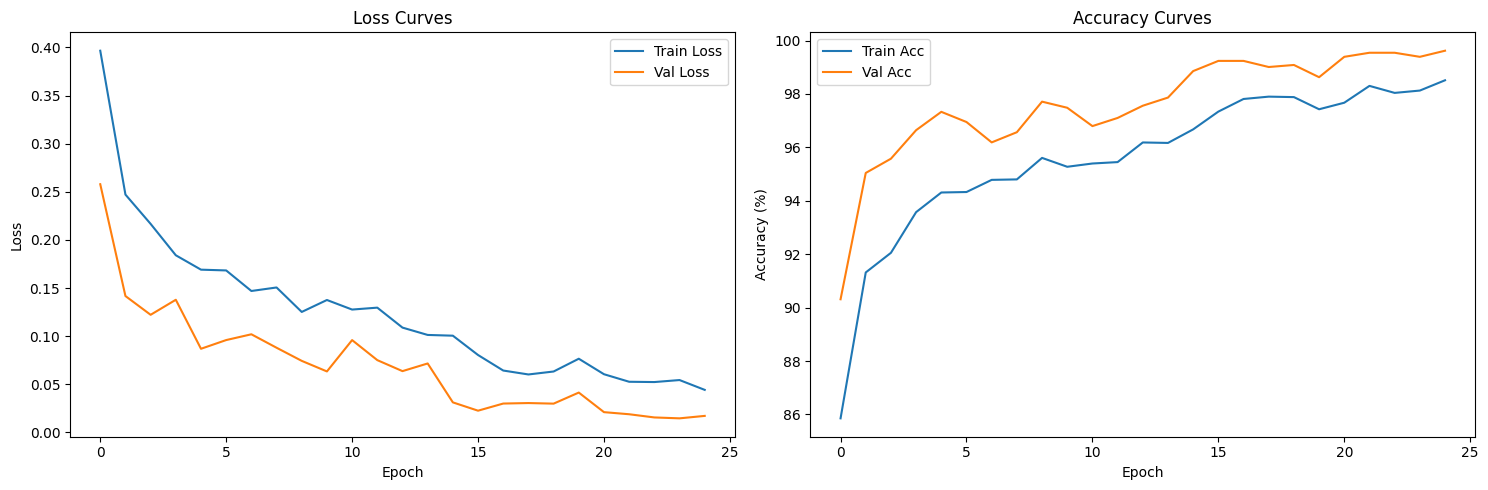


Epoch 26/30
--------------------
Batch [0/179] Loss: 0.0660
Batch [20/179] Loss: 0.0114
Batch [40/179] Loss: 0.0789
Batch [60/179] Loss: 0.0069
Batch [80/179] Loss: 0.0604
Batch [100/179] Loss: 0.0143
Batch [120/179] Loss: 0.2559
Batch [140/179] Loss: 0.0078
Batch [160/179] Loss: 0.0634
Train Loss: 0.0412, Train Acc: 98.63%
Val Loss: 0.0145, Val Acc: 99.31%

Epoch 27/30
--------------------
Batch [0/179] Loss: 0.0863
Batch [20/179] Loss: 0.0882
Batch [40/179] Loss: 0.0354
Batch [60/179] Loss: 0.2418
Batch [80/179] Loss: 0.0117
Batch [100/179] Loss: 0.0026
Batch [120/179] Loss: 0.0108
Batch [140/179] Loss: 0.0100
Batch [160/179] Loss: 0.0671
Train Loss: 0.0466, Train Acc: 98.18%
Val Loss: 0.0114, Val Acc: 99.62%

Epoch 28/30
--------------------
Batch [0/179] Loss: 0.0051
Batch [20/179] Loss: 0.0845
Batch [40/179] Loss: 0.0057
Batch [60/179] Loss: 0.0263
Batch [80/179] Loss: 0.0073
Batch [100/179] Loss: 0.1109
Batch [120/179] Loss: 0.1289
Batch [140/179] Loss: 0.0367
Batch [160/179] Lo

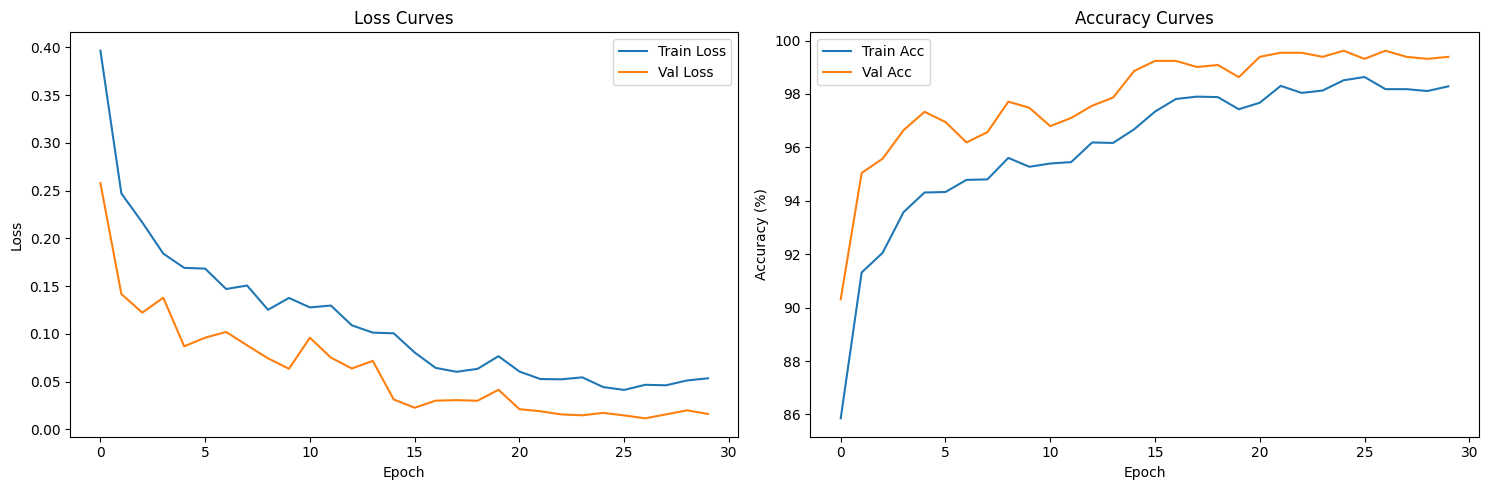

<ipython-input-10-7e348e1163cd>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


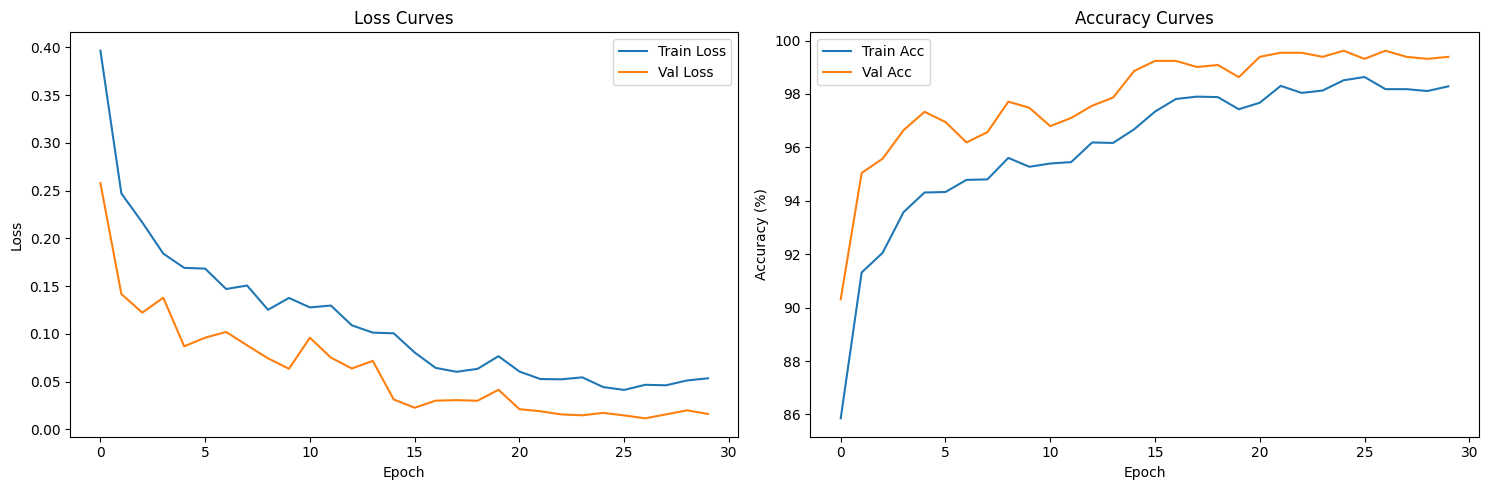

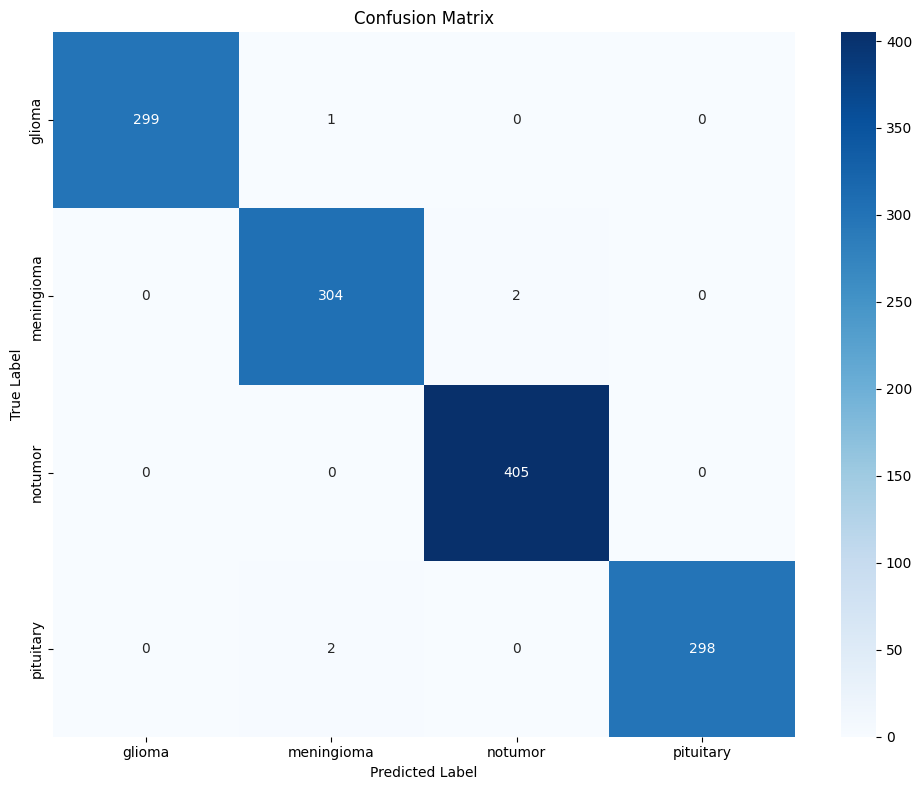


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [ ]:
# Cell 7: Run Training
if __name__ == '__main__':
    main()

In [ ]:
# Cell 8: Grad-CAM and Saliency Map Visualization
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam import GradCAM

def visualize_gradcam_saliency(model, dataset, device):
    """
    Generate and visualize Grad-CAM and saliency maps for a sample of images
    """
    # Choose a layer to focus on for Grad-CAM
    target_layer = model.model.conv_head  # EfficientNet specific final convolutional layer

    # Grad-CAM setup
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=(device.type == 'cuda'))

    # Select a sample of images for visualization
    indices = np.random.choice(len(dataset), size=5, replace=False)
    images, labels = [], []

    for idx in indices:
        img, label = dataset[idx]
        images.append(img)
        labels.append(label)

    images = torch.stack(images).to(device)  # Batch images
    targets = [ClassifierOutputTarget(label) for label in labels]

    # Generate Grad-CAM heatmaps
    grayscale_cams = cam(input_tensor=images, targets=targets)

    # Visualize results
    for i, grayscale_cam in enumerate(grayscale_cams):
        # Original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        # Apply Grad-CAM
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Original Image (Class: {dataset.classes[labels[i]]})")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Grad-CAM Visualization")
        plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Run Grad-CAM visualization on the validation dataset
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
val_dataset = BrainTumorDataset("/content/brain_tumor_data", get_transforms('val'), 'Testing')
visualize_gradcam_saliency(model, val_dataset, device)


<ipython-input-13-3350cf75789e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
<ipython-input-13-3350cf75789e>:64: Futu

TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'